# Introduction
Different steps to build a machine learning (ML) model for equitable clinical care associated with a ***categorical*** protected attribute. In this notebook, we will see how to:
1. Train a base model 
2. Auditing algorithmic bias
3. Dressing algorithmic bias by applying different bias mitigation strategies

Specifically, we build an ML model for depression using the NHANES dataset (https://wwwn.cdc.gov/nchs/nhanes/default.aspx). Here, we examine the behavior of the learned ML model with respect to protected attribute ***sex***

# Install library

In [ ]:
!pip install aif360
!pip install BlackBoxAuditing

# 1. Train a base model

In [ ]:
import pandas as pd
import numpy as np
from pandas import read_csv
from FairML.utils import dataset
from joblib import dump, load
from sklearn.model_selection import StratifiedKFold

# Defining x and y
full_df = pd.read_csv('Datasets/FullData_rm_dl_bt.csv', index_col='SEQN')
x = full_df.drop('depression', axis=1)
y = full_df['depression'].map({'Not Depressed': 0, 'Depressed': 1})

FOLDS = 10
k_fold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  lr_opt = dataset.nhanes_lr(X_train, y_train,None,i)
  dump(lr_opt, 'Models/nhanes/lr/model_{}.joblib'.format(i)) 

# 2. Auditing algorithmic bias

In [ ]:
from FairML.algorithms.benchmark import benchmark
# Defining x and y
full_df = pd.read_csv('Datasets/FullData_rm_dl_bt.csv', index_col='SEQN')
x = full_df.drop('depression', axis=1)
y = full_df['depression'].map({'Not Depressed': 0, 'Depressed': 1})

FOLDS = 10
k_fold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  cls_mdls = benchmark.benchmark(X_train,y_train,X_test,y_test,cls_mdls,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_base_nhanes_gender.csv', index=True)

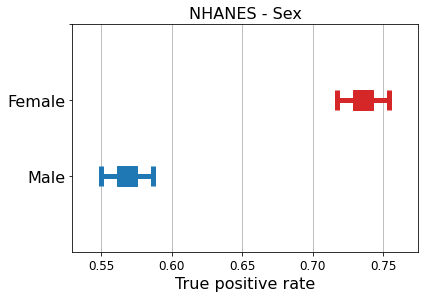

In [ ]:
from FairML.utils import plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
lr_base_nh = read_csv('Results/dataframe/lr_base_nhanes_gender.csv')
Group_sex = ['Male']*10 + ['Female']*10 + ['gender_female']*10
Value_class_rate = pd.concat([lr_base_nh['tpr_male'],\
                              lr_base_nh['tpr_female'],lr_base_nh['tpr_female']], axis = 0).to_numpy()
acc_age = {"Rate":Value_class_rate,"Group_sex": Group_sex} 
acc_age = pd.DataFrame(acc_age)                             
tukey = pairwise_tukeyhsd(groups=acc_age['Group_sex'], endog=acc_age['Rate'].values)
plot.plot_sim2(tukey,xlabel='True positive rate',n_g=2,m_g='gender_female')
plt.tight_layout()
plt.title("NHANES - Sex",fontsize=16)
plt.savefig('Results/img/lrnhanes-sex-tukey-base.png', dpi=1200,bbox_inches='tight')

# 3. Addressing algorithmic bias 

## 3.1 SUP

In [ ]:
from FairML.algorithms.preprocessing import sup
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  model_func = dataset.nhanes_lr
  sup1 = ['gender']
  cls_mdls = sup.sup(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_func,sup1)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_sup_nhanes_gender.csv', index=True)

## 3.2 RW

In [ ]:
from FairML.algorithms.preprocessing import rw
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  model_func = dataset.nhanes_lr
  cls_mdls = rw.rw(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_func)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_rw_nhanes_gender.csv', index=True)

## 3.3 DIR

In [ ]:
from FairML.algorithms.preprocessing import dir
cls_mdls = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  model_func = dataset.nhanes_lr
  sup = ['gender']
  cls_mdls = dir.dir_(X_train,y_train,X_test,y_test,cls_mdls,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,model_func,sup)
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_dir_nhanes_gender.csv', index=True)

# 3.4 CPP

In [ ]:
from FairML.algorithms.postprocessing import cpp
cls_mdls = {}
cls_cpp = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  cls_mdls, cls_cpp = cpp.cpp(X_train,y_train,X_test,y_test,cls_mdls,cls_cpp,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i)
cls_metrics_df = pd.DataFrame.from_dict(cls_cpp, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_cpp_nhanes_gender.csv', index=True)

## 3.5 PSTA

In [ ]:
from FairML.algorithms.postprocessing import psta
cls_mdls = {}
cls_3st = {}
for i, (train_index, test_index) in enumerate(k_fold.split(x,y)):
  X_train, X_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train, X_test = dataset.model_preparation_nhanes(X_train, X_test)
  model_path = 'Models/nhanes/lr/model_{}.joblib'.format(i) 
  unprivileged_groups, privileged_groups=[{'gender': 0}], [{'gender': 1}]
  conditions = [[{'gender':0}],[{'gender':1}]]
  label_name,protected_attribute_name = 'depression', 'gender'
  protected_attribute_values = ['male','female']
  unprivileged_value_3st=['gender',0]
  cls_mdls, cls_3st = psta.psta(X_train,y_train,X_test,y_test,cls_mdls,cls_3st,model_path,unprivileged_groups,privileged_groups,\
              conditions,label_name,protected_attribute_name,protected_attribute_values,i,\
              unprivileged_value_3st)
cls_metrics_df = pd.DataFrame.from_dict(cls_3st, 'index')
cls_metrics_df = cls_metrics_df.drop(['probs_test','preds_test'], axis=1)
cls_metrics_df.to_csv('Results/dataframe/lr_psta_nhanes_gender.csv', index=True)

## 3.6 Plot figures

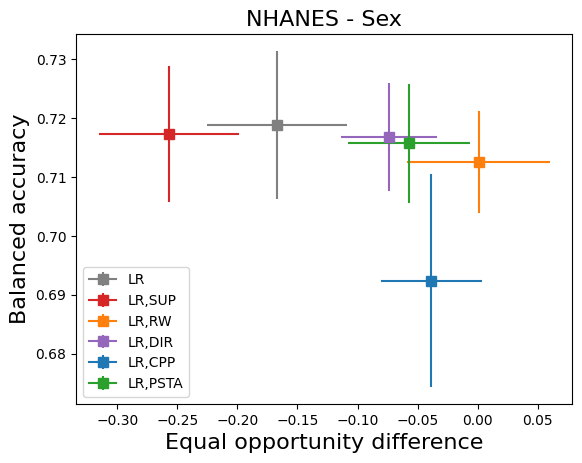

In [4]:
orig = read_csv('Results/dataframe/lr_base_nhanes_gender.csv')[['bacc_test','EOD']]
sup = read_csv('Results/dataframe/lr_sup_nhanes_gender.csv')[['bacc_test','EOD']]
rw = read_csv('Results/dataframe/lr_rw_nhanes_gender.csv')[['bacc_test','EOD']]
dir = read_csv('Results/dataframe/lr_dir_nhanes_gender.csv')[['bacc_test','EOD']]
cpp = read_csv('Results/dataframe/lr_cpp_nhanes_gender.csv')[['bacc_test','EOD']]
st = read_csv('Results/dataframe/lr_3st_nhanes_gender.csv')[['bacc_test','EOD']]
plot.plot_tradeoff(orig,sup,rw,dir,cpp,st,'NHANES - Sex','Results/img/lrnh-sex-tradeoff-size16.png')
plt.legend(['LR','LR,SUP',\
            'LR,RW','LR,DIR','LR,CPP','LR,PSTA'],
           loc='lower left',fancybox=True)

/content/drive/My Drive/PhD/code_npj/FairML/utils/plot.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sort_prot2, fontsize=16)


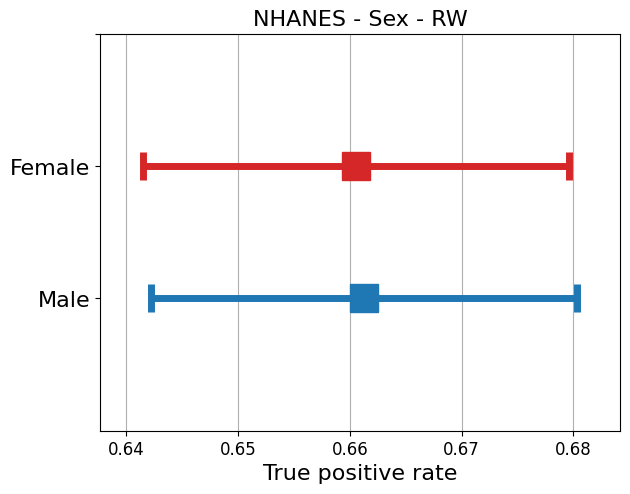

In [5]:
lr_base_nh = read_csv('Results/dataframe/lr_rw_nhanes_gender.csv')
Group_sex = ['Male']*10 + ['Female']*10 + ['gender_female']*10
Value_class_rate = pd.concat([lr_base_nh['tpr_male'],\
                              lr_base_nh['tpr_female'],lr_base_nh['tpr_female']], axis = 0).to_numpy()
acc_age = {"Rate":Value_class_rate,"Group_sex": Group_sex} 
acc_age = pd.DataFrame(acc_age)                             
tukey = pairwise_tukeyhsd(groups=acc_age['Group_sex'], endog=acc_age['Rate'].values)
plot.plot_sim2(tukey,xlabel='True positive rate',n_g=2,m_g='gender_female')
plt.tight_layout()
plt.title("NHANES - Sex - RW",fontsize=16)
plt.savefig('Results/img/lrnhanes-sex-tukey-rw.png', dpi=1200,bbox_inches='tight')